# Data Preprocessing

1. Forward fill then macro fill for individual patients
2. Artificially taking linear combinations to boost amount of patients with sepsis
3. Isolation Forest for anomaly detections

## 1. Packages

In [1]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE, ADASYN


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

print(os.getcwd())

C:\Users\mbdav\OneDrive\Documents\Sepsis\Notebooks


## 2. Importing Data

In [3]:
os.chdir(r'C:\\Users\\mbdav\\OneDrive\\Documents\\Sepsis\\datasets')
sepsis_train = pd.read_csv('train.csv')
os.chdir(r'C:\\Users\\mbdav\\OneDrive\\Documents\\Sepsis\\Notebooks')
sepsis_test = pd.read_csv('test.csv')



C:\Users\mbdav\AppData\Local\Temp\ipykernel_35268\2689051047.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  sepsis_test = pd.read_csv('test.csv')


In [4]:
print(sepsis_train.head())
print(sepsis_train.tail())
print('Rows', sepsis_train.shape[0])
print('Columns', sepsis_train.shape[1])
print(pd.Categorical(sepsis_train['SepsisLabel']))

print(sepsis_test.dtypes)
print(sepsis_train.dtypes)

   patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0    16426     1   NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN  ...   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0    NaN  ...   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0    NaN  ...   
3    16426     4  79.0  100.0  36.50  112.0  83.0  68.0  12.0    NaN  ...   
4    16426     5  73.0  100.0  36.50  115.0  80.0  64.0  11.0    NaN  ...   

    WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
1  14.2         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
2   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
3   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
4   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2    

In [5]:
sepsis_test['HR'] = pd.to_numeric(sepsis_test['HR'], errors='coerce')
print(sepsis_test['HR'])

0         110.0
1         103.0
2         105.0
3         118.0
4          99.0
          ...  
464349     88.0
464350     87.0
464351     88.0
464352      NaN
464353     89.0
Name: HR, Length: 464354, dtype: float64


## DATA CLEANING Impute Function

- Many NA values, so we have to do an imputation to fill the values
- The impute function first forward fills values across down the time steps by patient. Then you can either globally fill the median for the full matrix or you can locally fill the median for each variable for each patient.
- Imputation method choosen was the globally imputation method since the local imputation still left many NA values. If local imputation method was choosen more variables would need to be dropped and more observations would need to be dropped.

In [6]:
## Impute function

def impute(X, impute_type):
    #Forward Fill
    X_fill = X.groupby('patient').ffill()
    X_fill['patient'] = X['patient']
    

    ## Global fill 
    if impute_type == 'global':
        
        for column in X_fill.columns[1:]:  
            median_per_column = X_fill[column].median()
            X_fill[column].fillna(median_per_column, inplace=True)
        
    ## Local Fill
    if impute_type == 'local':
        for column in X_fill.columns[1:]:  
            median_per_patient = X_fill.groupby('patient')[column].median()
            X_fill[column] = X_fill[column].fillna(X_fill['patient'].map(median_per_patient))
    
    return X_fill
    


In [7]:
## FIlling
sepsis_fill_global = impute(sepsis_train, 'global')

print(sepsis_fill_global.isna().sum())
missing = sepsis_fill_global.isna().sum() / len(sepsis_fill_global) * 100
print(missing)

patient_index =1500
pd.set_option('display.max_columns', None)



C:\Users\mbdav\AppData\Local\Temp\ipykernel_35268\2422414756.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_fill[column].fillna(median_per_column, inplace=True)


time                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
Age                 0
Gender              0
Unit1               0
Unit2               0
HospAdmTime         0
ICULOS              0
SepsisLabel         0
patient             0
dtype: int64
time                0.0
HR               

In [8]:
## FIlling
sepsis_fill_test = impute(sepsis_test, 'global')

print(sepsis_fill_test.isna().sum())
missing = sepsis_fill_test.isna().sum() / len(sepsis_fill_test) * 100
print(missing)

patient_index =1500
pd.set_option('display.max_columns', None)


C:\Users\mbdav\AppData\Local\Temp\ipykernel_35268\2422414756.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_fill[column].fillna(median_per_column, inplace=True)


time                0
HR                  0
O2Sat               0
Temp                0
SBP                 0
MAP                 0
DBP                 0
Resp                0
EtCO2               0
BaseExcess          0
HCO3                0
FiO2                0
pH                  0
PaCO2               0
SaO2                0
AST                 0
BUN                 0
Alkalinephos        0
Calcium             0
Chloride            0
Creatinine          0
Bilirubin_direct    0
Glucose             0
Lactate             0
Magnesium           0
Phosphate           0
Potassium           0
Bilirubin_total     0
TroponinI           0
Hct                 0
Hgb                 0
PTT                 0
WBC                 0
Fibrinogen          0
Platelets           0
Age                 0
Gender              0
Unit1               0
Unit2               0
HospAdmTime         0
ICULOS              0
patient             0
dtype: int64
time                0.0
HR                  0.0
O2Sat          

In [9]:
## Eliminate heavy NA columns


sepsis_fill_global = sepsis_fill_global.drop(columns = ['Bilirubin_direct', 'EtCO2', 'TroponinI', 'Fibrinogen'])
print(sepsis_fill_global)


sepsis_fill_test = sepsis_fill_test.drop(columns = ['Bilirubin_direct', 'EtCO2', 'TroponinI', 'Fibrinogen'])
print(sepsis_fill_test)


         time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  \
0           1  83.0   98.0  36.83  121.0  81.0  62.0  18.0         0.0  24.0   
1           2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0  23.0   
2           3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0  23.0   
3           4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5  23.0   
4           5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5  23.0   
...       ...   ...    ...    ...    ...   ...   ...   ...         ...   ...   
1088192    37  88.0   98.0  36.90  122.0  82.0  61.0   9.0         0.0  24.0   
1088193    38  94.0   98.0  36.90  131.0  84.0  60.0   9.0         0.0  24.0   
1088194    39  90.0   93.0  36.40  113.0  85.0  68.0  13.0         0.0  24.0   
1088195    40  86.0   98.0  36.40  116.0  75.0  60.0   7.0         0.0  24.0   
1088196    41  88.0   99.0  36.40  140.0  94.0  71.0  12.0         0.0  24.0   

         FiO2    pH  PaCO2  SaO2   AST 

In [10]:
## Changing var typs


sepsis_train_final = sepsis_fill_global
sepsis_train_final['Gender'] = sepsis_fill_global['Gender'].round().astype(int)
sepsis_train_final['Unit1'] = sepsis_fill_global['Unit1'].round().astype(int)
sepsis_train_final['Unit2'] = sepsis_fill_global['Unit2'].round().astype(int)
sepsis_train_final['SepsisLabel'] = sepsis_fill_global['SepsisLabel'].round().astype(int)





print(sepsis_train_final)
sepsis_train_final.dtypes



         time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  \
0           1  83.0   98.0  36.83  121.0  81.0  62.0  18.0         0.0  24.0   
1           2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0  23.0   
2           3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0  23.0   
3           4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5  23.0   
4           5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5  23.0   
...       ...   ...    ...    ...    ...   ...   ...   ...         ...   ...   
1088192    37  88.0   98.0  36.90  122.0  82.0  61.0   9.0         0.0  24.0   
1088193    38  94.0   98.0  36.90  131.0  84.0  60.0   9.0         0.0  24.0   
1088194    39  90.0   93.0  36.40  113.0  85.0  68.0  13.0         0.0  24.0   
1088195    40  86.0   98.0  36.40  116.0  75.0  60.0   7.0         0.0  24.0   
1088196    41  88.0   99.0  36.40  140.0  94.0  71.0  12.0         0.0  24.0   

         FiO2    pH  PaCO2  SaO2   AST 

time                 int64
HR                 float64
O2Sat              float64
Temp               float64
SBP                float64
MAP                float64
DBP                float64
Resp               float64
BaseExcess         float64
HCO3               float64
FiO2               float64
pH                 float64
PaCO2              float64
SaO2               float64
AST                float64
BUN                float64
Alkalinephos       float64
Calcium            float64
Chloride           float64
Creatinine         float64
Glucose            float64
Lactate            float64
Magnesium          float64
Phosphate          float64
Potassium          float64
Bilirubin_total    float64
Hct                float64
Hgb                float64
PTT                float64
WBC                float64
Platelets          float64
Age                float64
Gender               int32
Unit1                int32
Unit2                int32
HospAdmTime        float64
ICULOS             float64
S

In [11]:
sepsis_train_final['THint'] = sepsis_train_final['Temp']*sepsis_train_final['HR']
sepsis_fill_test['THint'] = sepsis_fill_test['Temp']*sepsis_fill_test['HR']

sepsis_train_final['RHratio'] = sepsis_train_final['Resp']/sepsis_train_final['HR']
sepsis_fill_test['RHratio'] = sepsis_fill_test['Resp']/sepsis_fill_test['HR']

In [62]:
sepsis_fill_test.describe()
sepsis_fill_test.to_csv('test_df.csv', index=False)


In [63]:
sepsis_train_final.describe()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient,THint,RHratio
count,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06,1.088197e+06
mean,2.668297e+01,8.435343e+01,9.716375e+01,3.687089e+01,1.235132e+02,8.257228e+01,6.368341e+01,1.866645e+01,-5.837914e-02,2.414064e+01,4.439578e-01,7.390227e+00,4.027429e+01,9.593851e+01,6.886347e+01,2.191062e+01,7.900558e+01,8.089998e+00,1.058370e+02,1.333729e+00,1.304936e+02,1.705875e+00,2.030322e+00,3.477831e+00,4.078507e+00,1.067570e+00,3.159329e+01,1.058197e+01,3.373977e+01,1.108506e+01,2.012465e+02,6.196643e+01,5.605529e-01,3.019269e-01,6.980731e-01,-5.732940e+01,2.715587e+01,1.803166e-02,1.410742e+04,3.112857e+03,2.282021e-01
std,2.955474e+01,1.719778e+01,3.089261e+00,6.950583e-01,2.276514e+01,1.616166e+01,1.265188e+01,5.069080e+00,2.315128e+00,2.771874e+00,6.662822e+00,4.455280e-02,5.907366e+00,5.685500e+00,3.282822e+02,1.743179e+01,5.381272e+01,1.589960e+00,3.764953e+00,1.576653e+00,4.331600e+01,8.970224e-01,3.132373e-01,9.984395e-01,5.253117e-01,2.067371e+00,5.055735e+00,1.755740e+00,1.516843e+01,6.433434e+00,9.076206e+01,1.649518e+01,4.963200e-01,4.590940e-01,4.590940e-01,1.697154e+02,2.946175e+01,1.330659e-01,8.151722e+03,6.506281e+02,7.031245e-02
min,1.000000e+00,2.000000e+01,2.000000e+01,1.000000e+00,0.000000e+00,1.000000e+00,-1.843000e+01,1.000000e+00,-3.000000e+01,0.000000e+00,-5.000000e+01,6.720000e+00,1.000000e+01,2.300000e+01,3.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,2.600000e+01,1.000000e-01,1.000000e+01,2.000000e-01,2.000000e-01,3.000000e-01,1.000000e+00,1.000000e-01,5.500000e+00,2.300000e+00,1.250000e+01,1.000000e-01,1.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-5.366860e+03,1.000000e+00,0.000000e+00,1.000000e+00,6.000000e+01,6.250000e-03
25%,1.000000e+01,7.200000e+01,9.600000e+01,3.650000e+01,1.070000e+02,7.150000e+01,5.650000e+01,1.600000e+01,0.000000e+00,2.400000e+01,4.000000e-01,7.390000e+00,4.000000e+01,9.700000e+01,3.400000e+01,1.300000e+01,7.200000e+01,8.100000e+00,1.060000e+02,7.800000e-01,1.060000e+02,1.590000e+00,1.900000e+00,3.200000e+00,3.800000e+00,8.000000e-01,2.860000e+01,9.600000e+00,3.090000e+01,8.400000e+00,1.530000e+02,5.129000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.760000e+01,1.100000e+01,0.000000e+00,7.043000e+03,2.655400e+03,1.818182e-01
50%,2.000000e+01,8.300000e+01,9.800000e+01,3.683000e+01,1.210000e+02,8.100000e+01,6.200000e+01,1.800000e+01,0.000000e+00,2.400000e+01,4.000000e-01,7.390000e+00,4.000000e+01,9.700000e+01,3.400000e+01,1.700000e+01,7.200000e+01,8.300000e+00,1.060000e+02,9.000000e-01,1.220000e+02,1.590000e+00,2.000000e+00,3.400000e+00,4.000000e+00,8.000000e-01,3.120000e+01,1.050000e+01,3.090000e+01,1.030000e+01,1.890000e+02,6.400000e+01,1.000000e+00,0.000000e+00,1.000000e+00,-6.090000e+00,2.100000e+01,0.000000e+00,1.410100e+04,3.056890e+03,2.191781e-01
75%,3.400000e+01,9.500000e+01,9.900000e+01,3.728000e+01,1.380000e+02,9.200000e+01,6.900000e+01,2.100000e+01,0.000000e+00,2.400000e+01,4.000000e-01,7.390000e+00,4.000000e+01,9.700000e+01,3.400000e+01,2.300000e+01,7.200000e+01,8.600000e+00,1.060000e+02,1.200000e+00,1.420000e+02,1.590000e+00,2.100000e+00,3.500000e+00,4.300000e+00,8.000000e-01,3.410000e+01,1.140000e+01,3.090000e+01,1.250000e+01,2.310000e+02,7.402000e+01,1.000000e+00,1.000000e+00,1.000000e+00,-4.000000e-02,3.500000e

In [12]:
## More Packs
!pip install mlxtend
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import GridSearchCV
from scipy import stats



## Train/Test and SMOTE

In [13]:
##Train/val

unique_patients = sepsis_train_final['patient'].unique()

train_patients, val_patients = train_test_split(unique_patients, test_size=0.15, random_state=10)

X_train = sepsis_train_final[sepsis_train_final['patient'].isin(train_patients)]
X_val = sepsis_train_final[sepsis_train_final['patient'].isin(val_patients)]

y_train = X_train['SepsisLabel']
y_val = X_val['SepsisLabel']


X_train = X_train.drop(columns=['SepsisLabel'])
X_val = X_val.drop(columns=['SepsisLabel'])

print("Training Set:")
print(X_train)
print("\nValidation Set:")
print(X_val)

Training Set:
         time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  \
0           1  83.0   98.0  36.83  121.0  81.0  62.0  18.0         0.0  24.0   
1           2  78.0   99.5  35.25  108.5  84.5  69.0  12.0         0.0  23.0   
2           3  80.0   99.0  36.20  113.0  87.0  73.0  12.0         0.0  23.0   
3           4  79.0  100.0  36.50  112.0  83.0  68.0  12.0        -2.5  23.0   
4           5  73.0  100.0  36.50  115.0  80.0  64.0  11.0        -2.5  23.0   
...       ...   ...    ...    ...    ...   ...   ...   ...         ...   ...   
1088151    35  73.0   95.0  37.06   94.0  59.0  44.0  21.0        -3.0  23.0   
1088152    36  73.0   96.0  37.61  108.0  64.5  46.0  20.0        -3.0  23.0   
1088153    37  73.0   95.0  37.61   88.0  54.0  39.0  21.0        -3.0  23.0   
1088154    38  73.0   95.0  37.61   95.0  58.0  42.0  22.0        -3.0  23.0   
1088155    39  73.0   96.0  37.61  106.0  60.0  44.0  20.0        -3.0  21.0   

         FiO2    pH  PaCO

In [14]:
X_train_patient_ids = X_train['patient'].unique()
X_val_patient_ids = X_val['patient'].unique()

# Convert to sets for comparison
train_set = set(X_train_patient_ids)
val_set = set(X_val_patient_ids)

# Check for intersection
common_patients = train_set.intersection(val_set)

# Output the result
if common_patients:
    print(f"Common patient IDs between y_train and y_val: {common_patients}")
else:
    print("No common patient IDs between y_train and y_val.")

No common patient IDs between y_train and y_val.


In [45]:
X_train.describe()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,patient,ShockIndex,RHratio
count,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.00000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.00000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,924554.000000,9.245540e+05,924554.000000
mean,26.690708,84.273977,97.166655,36.869567,123.548897,82.57878,63.663716,18.668270,-0.053444,24.152147,0.445278,7.390307,40.277824,95.904176,69.813669,21.891038,79.10491,8.090347,105.832824,1.335151,130.411020,1.705909,2.031084,3.478610,4.078907,1.067335,31.600286,10.585697,33.706176,11.055806,200.951258,62.008039,0.561401,0.302780,0.697220,-56.588049,27.169707,14131.891170,inf,0.228395
std,29.665489,17.134644,3.087645,0.694761,22.793368,16.20016,12.669146,5.065234,2.305441,2.768355,7.228265,0.044613,5.871482,5.775903,332.611508,17.463623,54.79527,1.591057,3.741882,1.585314,43.035103,0.890158,0.313287,0.997785,0.526019,2.055611,5.057526,1.757791,14.983199,5.906976,90.549734,16.474167,0.496216,0.459461,0.459461,165.680541,29.557594,8160.824362,NaN,0.070206
min,1.000000,21.000000,20.000000,1.000000,0.000000,1.00000,-18.430000,1.000000,-30.000000,0.000000,-50.000000,6.720000,10.000000,23.000000,3.000000,1.000000,7.00000,1.000000,26.000000,0.100000,10.000000,0.200000,0.200000,0.300000,1.000000,0.100000,5.500000,2.600000,12.500000,0.100000,1.000000,14.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,2.000000,1.415929e-01,0.006667
25%,10.000000,72.000000,96.000000,36.500000,107.000000,71.33000,56.000000,16.000000,0.000000,24.000000,0.400000,7.390000,40.000000,97.000000,34.000000,13.000000,72.00000,8.100000,106.000000,0.770000,106.000000,1.590000,1.900000,3.200000,3.800000,0.800000,28.600000,9.600000,30.900000,8.400000,152.000000,51.460000,0.000000,0.000000,0.000000,-47.430000,11.000000,7017.000000,5.639098e-01,0.181818
50%,20.000000,83.000000,98.000000,36.830000,121.000000,81.00000,62.000000,18.000000,0.000000,24.000000,0.400000,7.390000,40.000000,97.000000,34.000000,17.000000,72.00000,8.300000,106.000000,0.900000,122.000000,1.590000,2.000000,3.400000,4.000000,0.800000,31.200000,10.500000,30.900000,10.300000,189.000000,64.000000,1.000000,0.000000,1.000000,-6.060000,21.000000,14130.000000,6.859504e-01,0.219178
75%,34.000000,95.000000,99.000000,37.280000,138.000000,92.00000,69.000000,21.000000,0.000000,24.000000,0.400000,7.390000,40.000000,97.000000,34.000000,23.000000,72.00000,8.600000,106.000000,1.200000,142.000000,1.590000,2.100000,3.500000,4.300000,0.800000,34.100000,11.400000,30.900000,12.400000,231.000000,74.070000,1.000000,1.000000,1.000000,-0.040000,34.000000,21226.000000,8.190476e-01,0.265823
max,425.000000,211.000000,100.000000,50.000000,300.000000,300.00000,300.000000,102.000000,100.000000,55.000000,4000.000000,7.930000,100.000000,100.000000,9961.000000,266.000000,2528.00000,27.900000,145.000000,46.600000,988.000000,28.900000,9.600000,18.800000,27.500000,49.600000,71.700000,32.000000,250.000000,440.000000,2322.000000,100.000000,1.000000,1.000000,1.000000,20.040000,336.000000,28235.000000,inf,1.700000


In [67]:
## Smote

smo= SMOTE(sampling_strategy=0.35, k_neighbors=5, random_state=47) 
X_train, y_train = smo.fit_resample(X_train, y_train)
val_patient_ids = X_val['patient'].unique()

# Drop patient IDs from the training set that are in the validation set
X_train_filtered = X_train[~X_train['patient'].isin(val_patient_ids)]

# Display the shape of the filtered training set
print("Original training set shape:", X_train.shape)
print("Filtered training set shape:", X_train_filtered.shape)


y_train_filtered = y_train[X_train['patient'].isin(val_patient_ids) == False]


print("Filtered y_train shape:", y_train_filtered.shape)
print(X_train_filtered)


Original training set shape: (1225713, 40)
Filtered training set shape: (1211716, 40)
Filtered y_train shape: (1211716,)
         time          HR       O2Sat       Temp         SBP         MAP  \
0           1   83.000000   98.000000  36.830000  121.000000   81.000000   
1           2   78.000000   99.500000  35.250000  108.500000   84.500000   
2           3   80.000000   99.000000  36.200000  113.000000   87.000000   
3           4   79.000000  100.000000  36.500000  112.000000   83.000000   
4           5   73.000000  100.000000  36.500000  115.000000   80.000000   
...       ...         ...         ...        ...         ...         ...   
1225708    34  146.000000   99.000000  39.000000   98.707150   66.585701   
1225709     5   86.000000  100.000000  36.313767  108.638835   78.902911   
1225710    66  107.000000  100.000000  37.175043   96.623927   67.656556   
1225711    11   84.045926   97.614815  36.743111  137.918521  100.505187   
1225712     4  118.000000   95.000000  36.8

In [42]:
y_train.value_counts()

SepsisLabel
0    907936
1    317777
Name: count, dtype: int64

In [68]:
print(X_train_filtered)
X_train_patient_ids = X_train_filtered['patient'].unique()
X_val_patient_ids = X_val['patient'].unique()


train_set = set(X_train_patient_ids)
val_set = set(X_val_patient_ids)

# Check for intersection
common_patients = train_set.intersection(val_set)


if common_patients:
    print(f"Common patient IDs between y_train and y_val: {common_patients}")
else:
    print("No common patient IDs between y_train and y_val.")
len(common_patients)


         time          HR       O2Sat       Temp         SBP         MAP  \
0           1   83.000000   98.000000  36.830000  121.000000   81.000000   
1           2   78.000000   99.500000  35.250000  108.500000   84.500000   
2           3   80.000000   99.000000  36.200000  113.000000   87.000000   
3           4   79.000000  100.000000  36.500000  112.000000   83.000000   
4           5   73.000000  100.000000  36.500000  115.000000   80.000000   
...       ...         ...         ...        ...         ...         ...   
1225708    34  146.000000   99.000000  39.000000   98.707150   66.585701   
1225709     5   86.000000  100.000000  36.313767  108.638835   78.902911   
1225710    66  107.000000  100.000000  37.175043   96.623927   67.656556   
1225711    11   84.045926   97.614815  36.743111  137.918521  100.505187   
1225712     4  118.000000   95.000000  36.830000  141.000000  122.000000   

                DBP       Resp  BaseExcess       HCO3      FiO2        pH  \
0         

0

In [69]:
print(y_val)
print(y_train.value_counts())

200        0
201        0
202        0
203        0
204        0
          ..
1088192    0
1088193    0
1088194    0
1088195    0
1088196    0
Name: SepsisLabel, Length: 163643, dtype: int32
SepsisLabel
0    907936
1    317777
Name: count, dtype: int64


In [15]:
from sklearn.ensemble import IsolationForest
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  


iso_forest.fit(X_train_filtered)

# Predict anomalies (-1 for outliers, 1 for inliers)
anomaly_scores = iso_forest.predict(X_train_filtered)

# Add the anomaly predictions 
X_train_filtered['Anomaly'] = anomaly_scores
print(X_train_filtered)

NameError: name 'X_train_filtered' is not defined

In [71]:

print(X_train_filtered['Anomaly'].value_counts())


# Filter out anomalies
anomalies = X_train_filtered[X_train_filtered['Anomaly'] == -1]
anomaly_indices = anomalies.index.tolist()
print(anomalies.head())
print(X_train_filtered)


Anomaly
 1    1199598
-1      12118
Name: count, dtype: int64
      time     HR  O2Sat   Temp    SBP    MAP    DBP  Resp  BaseExcess  HCO3  \
3062   122  114.0   95.0  36.83  178.0  125.0  101.0  34.0        -3.0  22.0   
3091   151  120.0   95.0  36.83  159.0   96.0   62.0  30.5         1.0  23.0   
3092   152  122.0   96.0  36.83  157.0   97.0   65.0  34.0         1.0  23.0   
3093   153  114.0   97.0  36.83  139.0   83.0   56.0  31.0         1.0  23.0   
3094   154  114.0   97.0  36.83  152.0   99.0   69.0  26.0         1.0  23.0   

      FiO2    pH  PaCO2  SaO2    AST   BUN  Alkalinephos  Calcium  Chloride  \
3062   0.6  7.35   39.0  97.0   56.0  60.0          50.0      8.9      87.0   
3091   0.5  7.49   31.0  96.0  199.0  34.0         354.0     10.8      93.0   
3092   0.5  7.49   31.0  96.0  199.0  34.0         354.0     10.8      93.0   
3093   0.5  7.49   31.0  96.0  199.0  34.0         354.0     10.8      93.0   
3094   0.5  7.49   31.0  96.0  199.0  34.0         354.0     1

In [72]:
anomalies = X_train_filtered[X_train_filtered['Anomaly'] == -1]
X_train_filtered = X_train_filtered[X_train_filtered['Anomaly'] != -1]

non_anomaly_indices = X_train_filtered.index.tolist()

y_train_filtered = y_train_filtered[non_anomaly_indices]


X_train_filtered = X_train_filtered.drop(columns=['Anomaly'])
print(X_train_filtered)
print(X_train_filtered)
print("Cleaned X_train shape:", X_train.shape)
print("Cleaned y_train shape:", y_train.shape)

         time          HR       O2Sat       Temp         SBP         MAP  \
0           1   83.000000   98.000000  36.830000  121.000000   81.000000   
1           2   78.000000   99.500000  35.250000  108.500000   84.500000   
2           3   80.000000   99.000000  36.200000  113.000000   87.000000   
3           4   79.000000  100.000000  36.500000  112.000000   83.000000   
4           5   73.000000  100.000000  36.500000  115.000000   80.000000   
...       ...         ...         ...        ...         ...         ...   
1225708    34  146.000000   99.000000  39.000000   98.707150   66.585701   
1225709     5   86.000000  100.000000  36.313767  108.638835   78.902911   
1225710    66  107.000000  100.000000  37.175043   96.623927   67.656556   
1225711    11   84.045926   97.614815  36.743111  137.918521  100.505187   
1225712     4  118.000000   95.000000  36.830000  141.000000  122.000000   

                DBP       Resp  BaseExcess       HCO3      FiO2        pH  \
0         

In [73]:
X_train_patient_ids = X_train_filtered['patient'].unique()
X_val_patient_ids = X_val['patient'].unique()

# Convert to sets
train_set = set(X_train_patient_ids)
val_set = set(X_val_patient_ids)

# Check for intersection
common_patients = train_set.intersection(val_set)


if common_patients:
    print(f"Common patient IDs between y_train and y_val: {common_patients}")
else:
    print("No common patient IDs between y_train and y_val.")
len(common_patients)

No common patient IDs between y_train and y_val.


0

In [74]:

train_df = X_train_filtered
train_df['SepsisLabel'] = y_train_filtered
print(train_df)



val_df = X_val
val_df['SepsisLabel'] = y_val

print(val_df.describe())
print(train_df.describe())

         time          HR       O2Sat       Temp         SBP         MAP  \
0           1   83.000000   98.000000  36.830000  121.000000   81.000000   
1           2   78.000000   99.500000  35.250000  108.500000   84.500000   
2           3   80.000000   99.000000  36.200000  113.000000   87.000000   
3           4   79.000000  100.000000  36.500000  112.000000   83.000000   
4           5   73.000000  100.000000  36.500000  115.000000   80.000000   
...       ...         ...         ...        ...         ...         ...   
1225708    34  146.000000   99.000000  39.000000   98.707150   66.585701   
1225709     5   86.000000  100.000000  36.313767  108.638835   78.902911   
1225710    66  107.000000  100.000000  37.175043   96.623927   67.656556   
1225711    11   84.045926   97.614815  36.743111  137.918521  100.505187   
1225712     4  118.000000   95.000000  36.830000  141.000000  122.000000   

                DBP       Resp  BaseExcess       HCO3      FiO2        pH  \
0         

In [79]:
train_df.to_csv('train_df.csv', index=False)

val_df.to_csv('val_df.csv', index=False)


In [78]:
y_train_patient_ids = train_df['patient'].unique()
y_val_patient_ids = val_df['patient'].unique()


train_set = set(y_train_patient_ids)
val_set = set(y_val_patient_ids)

# Check for intersection
common_patients = train_set.intersection(val_set)


if common_patients:
    print(f"Common patient IDs between y_train and y_val: {common_patients}")
else:
    print("No common patient IDs between y_train and y_val.")

No common patient IDs between y_train and y_val.


## Standardization

- We use min-max scaling throughout our models

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

dummy_vars = ['Gender', 'Unit1', 'Unit2', 'time', 'patient']    # List of dummy variable column names
feature_cols = X_train_filtered.columns.difference(dummy_vars)

# Min-Scaling
scaler = MinMaxScaler()
train_x_scaled = X_train_filtered.copy()
valid_x_scaled = X_val.copy()
test_x_scaled = sepsis_fill_test.copy()

train_x_scaled[feature_cols] = scaler.fit_transform(train_x_scaled[feature_cols])
valid_x_scaled[feature_cols] = scaler.transform(valid_x_scaled[feature_cols])
test_x_scaled[feature_cols] = scaler.transform(test_x_scaled[feature_cols])









## Logistic Regression

In [89]:
X_train_scaleds = sm.add_constant(X_train_scaled)
X_val_scaleds = sm.add_constant(X_val_scaled)

logit = sm.Logit(y_train, X_train_scaleds)
result1 = logit.fit()
print(result1.summary())


         Current function value: 0.495418
         Iterations: 35


C:\Users\mbdav\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1213921
Model:                          Logit   Df Residuals:                  1213884
Method:                           MLE   Df Model:                           36
Date:                Wed, 23 Oct 2024   Pseudo R-squ.:                  0.1298
Time:                        16:07:24   Log-Likelihood:            -6.0140e+05
converged:                      False   LL-Null:                   -6.9114e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8081   1.22e+05  -6.61e-06      1.000    -2.4e+05     2.4e+05
x1             0.2473      0.002     99.069      0.000       0.242       0.252
x2             0.0236      0.002     10.376      0.0

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [91]:

y_pred = result1.predict(X_val_scaleds)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
accuracy1 = accuracy_score(Y_val, y_pred_binary)
f11 = f1_score(Y_val, y_pred_binary)
conf1 = confusion_matrix(Y_val, y_pred_binary)
print(conf1)
print(accuracy1)
print(f11)


[[153838   6453]
 [  2183    756]]
0.9470930588739815
0.14899487583760349


## Random Forests

In [25]:
## RF
param_grid = {'max_features': ['sqrt', 'log2', .5, .8], 
             'n_estimators': [100],
             'max_depth': [3]}
rf = RF(random_state = 21)
grid_rf = GridSearchCV(estimator=rf, param_grid = param_grid, cv = 3, scoring='f1', n_jobs = -1)
rf_results = grid_rf.fit(X_train_scaled, y_train)



In [27]:
features = grid_rf.best_params_['max_features']
print("Best Parameters:", grid_rf.best_params_)
print("best F1 :", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
fn = X_train.columns

feature_importance = pd.DataFrame(
    {'importance ':best_rf.feature_importances_},
    index=fn)
print(feature_importance.sort_values(by='importance ', ascending=False))


Best Parameters: {'max_depth': 3, 'max_features': 0.8, 'n_estimators': 100}
best F1 : 0.5132586970736571
                  importance 
ICULOS           5.892450e-01
FiO2             1.660166e-01
time             1.525396e-01
Temp             6.952273e-02
HR               8.699104e-03
O2Sat            5.252879e-03
AST              4.446185e-03
Lactate          1.101957e-03
HCO3             1.028168e-03
WBC              7.935345e-04
PaCO2            3.797762e-04
Resp             3.438748e-04
DBP              3.430067e-04
MAP              2.577647e-04
Hgb              2.952854e-05
SBP              2.542437e-07
PTT              0.000000e+00
Hct              0.000000e+00
HospAdmTime      0.000000e+00
Platelets        0.000000e+00
Age              0.000000e+00
Potassium        0.000000e+00
Bilirubin_total  0.000000e+00
Calcium          0.000000e+00
Phosphate        0.000000e+00
Magnesium        0.000000e+00
Glucose          0.000000e+00
Creatinine       0.000000e+00
Chloride         0.000000

In [29]:
y_pred_rf1 = rf_results.predict(X_val_scaled)
y_pred_binary_rf1 = np.where(y_pred_rf1 > 0.5, 1, 0)
accuracyfr1 = accuracy_score(Y_val, y_pred_binary_rf1)
f1rf1= f1_score(Y_val, y_pred_binary_rf1)
confrf1 = confusion_matrix(Y_val, y_pred_binary_rf1)
print(confrf1)
print(accuracyfr1)
print(f1rf1)

[[150602   9634]
 [  1907   1087]]
0.9292960852784414
0.15851257746992345


In [41]:
## Fully loaded global no grid search: WARNING This will take a long time to run since the number of estimators is 10x
rf = RF(max_features = .8, random_state = 21)
rf_results4 = rf.fit(train_x_scaled, y_train_filtered)
fn = train_x_scaled.columns

feature_importance = pd.DataFrame(
    {'importance ':rf_results4.feature_importances_},
    index=fn)
print(feature_importance.sort_values(by='importance ', ascending=False))



                 importance 
ICULOS              0.211181
HospAdmTime         0.048233
Age                 0.044112
Temp                0.042248
time                0.040583
Resp                0.040578
WBC                 0.033227
Platelets           0.032397
FiO2                0.027650
Lactate             0.026962
HR                  0.026793
BUN                 0.025453
PTT                 0.023872
Creatinine          0.022680
Glucose             0.021028
Calcium             0.020479
BaseExcess          0.020377
Hct                 0.019427
Hgb                 0.018836
O2Sat               0.018323
Potassium           0.018129
Phosphate           0.018092
Alkalinephos        0.017888
Chloride            0.017764
AST                 0.017541
pH                  0.017002
Magnesium           0.016935
PaCO2               0.016026
HCO3                0.015683
Bilirubin_total     0.014944
SaO2                0.014311
DBP                 0.012477
SBP                 0.011657
MAP           

NameError: name 'val_x_scaled' is not defined

In [42]:
y_pred_rf4 = rf_results4.predict(valid_x_scaled)
y_pred_binary_rf4 = np.where(y_pred_rf4 > 0.5, 1, 0)
accuracyfr4 = accuracy_score(y_val, y_pred_binary_rf4)
f1rf4= f1_score(y_val, y_pred_binary_rf4)
confrf4 = confusion_matrix(y_val, y_pred_binary_rf4)
print(confrf4) 
print(accuracyfr4)
print(f1rf4)


[[160239    400]
 [  2947     57]]
0.979546940596298
0.03293845709332563


In [ ]:

predictions = rf_results4.predict(test_x_scaled)

sepsis_labels = (predictions > 0.5).astype(int)

patient_ids = [f"{patient_id}_{timestep + 1}" for patient_id in range(num_patients) for timestep in range(num_timesteps)]


output_df = pd.DataFrame({
    'ID': patient_ids,
    'SepsisLabel': sepsis_labels.flatten() 
})

# Show the output DataFrame
print(output_df)

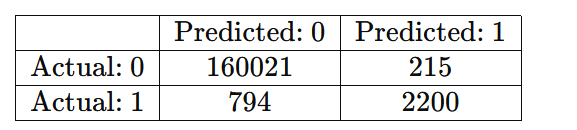